In [8]:
import numpy as np
import math as math
import cmath as cmath
import psutil as psutil
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from matplotlib import gridspec as gridspec
import argparse as argparse
import operator as operator
import warnings as warnings
import copy as copy
import time as time
import pdb
import os as os
import random
import k2
import libcarma as libcarma
import util.mcmcviz as mcmcviz
import s82
from util.mpl_settings import set_plot_params
import util.triangle as triangle
import cPickle as pickle
%matplotlib inline

# Combining SDSS and K2 Lightcurves

In [9]:
#Loading SDSS g and r band flux lightcurves: object #1
sdsslc_r = s82.sdssLC(name = '005102.42-010244.4', band = 'r')
sdsslc_g = s82.sdssLC(name = '005102.42-010244.4', band = 'g')

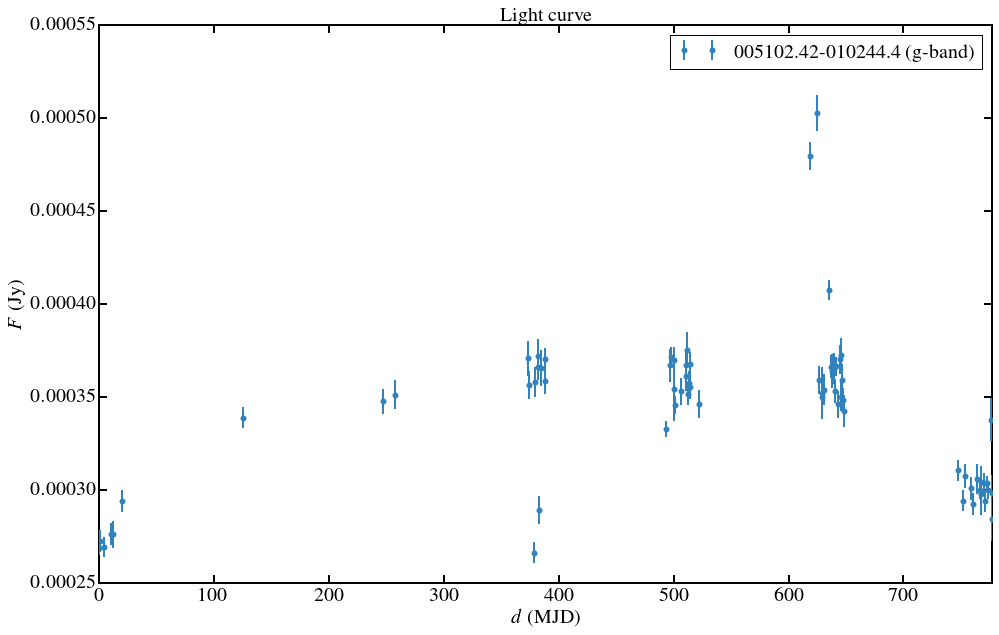

In [12]:
#plot lightcurves for band r and g
a = sdsslc_r.plot()
b = sdsslc_g.plot()



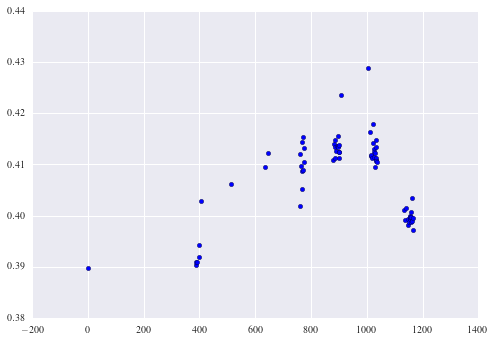

In [27]:
# make new kepler flux
c = pow(sdsslc_r.y, 0.2) + pow(sdsslc_g.y,0.2)
c_err = pow(sdsslc_r.yerr, 0.2) + pow(sdsslc_g.yerr,0.8)
c_t = sdsslc_r.t
import seaborn as sns
#plt.errorbar(sdsslc_r.t, c, yerr = c_err)
plt.scatter(c_t, c)

('the average flux is %d', 0.41072368851570423)


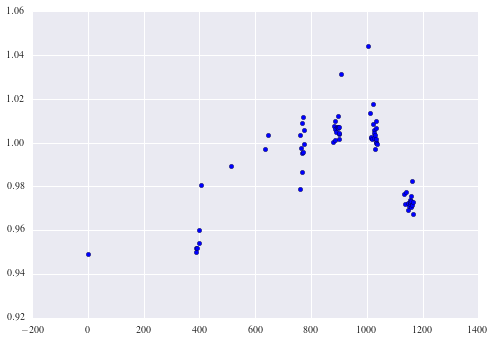

In [45]:
#sanity check: Is the lightcurve normalized? Answer : yes
c_med = np.median(c)
c_norm = c/c_med
print("the average flux is %d",c_med)
plt.scatter(sdsslc_r.t, c_norm)

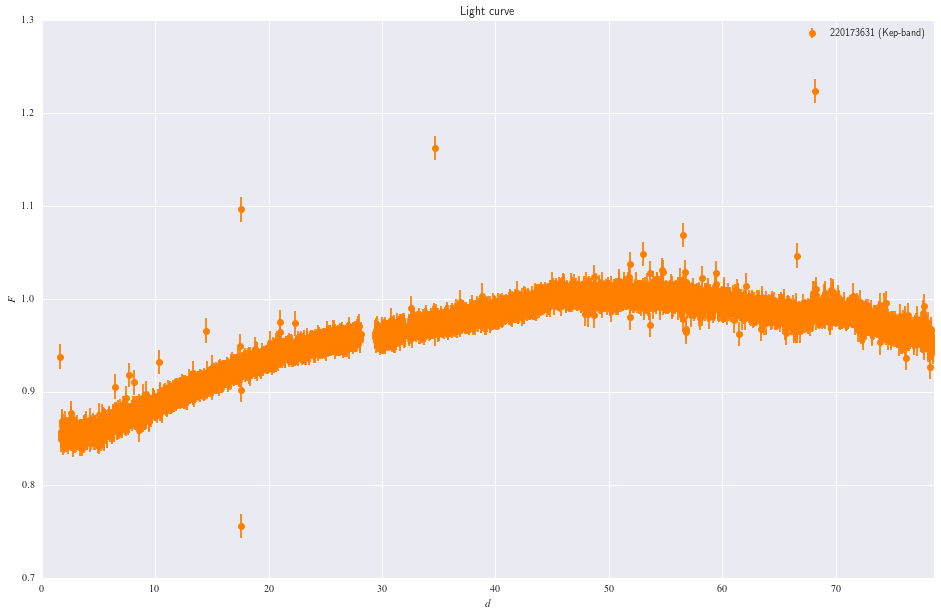

In [41]:
#load k2 lighturve for the same QSO
k2lc = k2.k2LC(name = '220173631', band = 'Kep', processing = 'k2sff', campaign = 'c08')
everLC = k2.k2LC(name = '220173631', band = 'Kep', processing = 'everest', campaign = 'c08')
k2plot = k2lc.plot()

# Plotting Combined lightcurve

[   0.          387.43419041  387.77977762 ...,   78.66204641   78.68247839
   78.70291026]


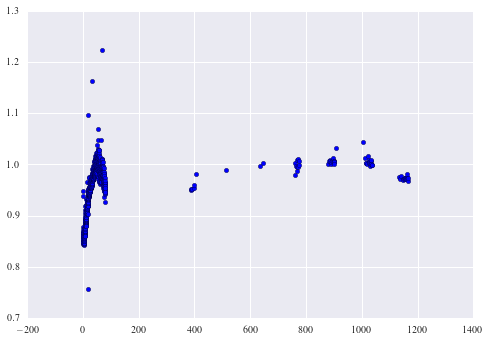

In [43]:

full_lcy = np.concatenate([c_norm, np.array(k2lc.y)])
full_lct = np.concatenate([c_t, np.array(k2lc.t)])
w = np.where(full_lcy > 0)[0]
plt.scatter(full_lct[w], full_lcy[w])
print full_lct
# t is rest to days starting from t = 0, calculate the number of days and add offset to k2 
#something appears to be wrong with the time grid for sdss

(70, 3853, 3923)
[    0.           387.43419041   387.77977762 ...,  3388.66204641
  3388.68247839  3388.70291026]


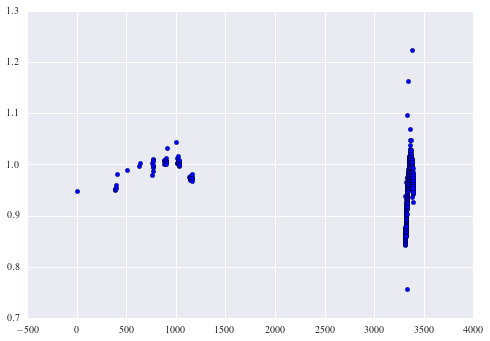

In [59]:
#compare time attibutes in sdss and k2 objects from kali
print(len(sdsslc_g.t), len(k2lc.t),len(full_lct))
k2t = k2lc.t + 3310.
full_lct = np.concatenate([c_t, k2t])
w = np.where(full_lcy > 0)[0]
plt.scatter(full_lct[w], full_lcy[w])
print full_lct
#import pandas as p
#d = {'sdss': sdsslc_g.t, 'k2': k2lc.t,'combo': full_lct}
#df = p.DataFrame(data=d, index = np.arange(len(full_lct)))


